In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *

In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
unfilt_ab = od+expand(config['lr']['cerberus']['ab'], species='human')[0] 
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]

ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]

ver = 'v40_cerberus'
m_ver = 'vM25_cerberus'
min_tpm = 1
gene_subset = 'polya'
obs_col = 'sample'
go_gene_subset = 'protein_coding'
predom_iso_subset = 'protein_coding'
dist_gene_subset = 'protein_coding'

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]
m_cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='mouse', obs_col='sample')[0]
m_swan_file = od+expand(config['lr']['swan']['sg'], species='mouse')[0]
m_filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='mouse')[0]



## Dist. of # reads / library

In [15]:
meta = pd.read_csv(lib_meta, sep='\t')
meta = pd.concat([meta, pd.read_csv(m_lib_meta, sep='\t')], axis=0)

In [16]:
# sns.displot(meta, x='reads_post_talon', kind='hist', binwidth=100000)
dataset = 'cortex_14d_f_2'
n = len(meta.index)
n_num = len(meta.loc[meta.reads_post_talon<meta.loc[meta.dataset==dataset, 'reads_post_talon'].values[0]].index)
print(f'{perc(n_num, n):.2f}% ({n_num}/{n}) of libraries have fewer reads than {dataset}')

21.51% (57/265) of libraries have fewer reads than cortex_14d_f_2


In [17]:
ca = cerberus.read(m_cerberus_h5)
sg = swan.read(m_swan_file)
filt_ab_df = pd.read_csv(m_filt_ab, sep='\t')
obs_col = 'dataset'
min_tpm = 1
dataset = 'cortex_14d_f_2'

Read in graph from ../../proc_revisions/data/mouse/lr/swan/swan_graph.p


In [18]:
# library-level observed triplets
df = ca.get_expressed_triplets(sg,
                               obs_col=obs_col,
                               min_tpm=min_tpm,
                               source='dataset_det')
df.to_csv(f'{dataset}_triplets.tsv', sep='\t')

In [8]:
df = pd.read_csv('dataset_triplets.tsv', sep='\t')

In [9]:
# get just the stuff with cortex_14d_f_2
subset_df = df.loc[df.dataset==dataset].copy(deep=True)
subset_df.head()

# which genes only had one isoform?
gids = subset_df.loc[subset_df.n_iso==1, 'gid'].tolist()

In [10]:
# now get the gene triplets for the entire sample
# (expressed genes from any replicate; ie higher sampling depth)
meta = pd.read_csv(m_lib_meta, sep='\t')
sample = meta.loc[meta.dataset == dataset, 'sample'].values[0]

rep_df = ca.triplets.loc[ca.triplets['sample'] == sample].copy(deep=True)

In [11]:
# limit to the gids where we only had one isoform in the lowly-sequenced library
print(len(rep_df.index))
rep_df = rep_df.loc[rep_df.gid.isin(gids)]
print(len(rep_df.index))

30506
7998


In [12]:
# count the genes that still have 1 transcript / gene and those that now have more 
# when upscaling like this
rep_df = rep_df[['gid', 'n_iso']].groupby('n_iso').count().reset_index().rename({'gid':'n_genes'}, axis=1)
rep_df.head()

,n_iso,n_genes
0,1.0,4692
1,2.0,1933
2,3.0,822
3,4.0,342
4,5.0,135


In [13]:
rep_df['total'] = rep_df.n_genes.sum(axis=0)
rep_df['perc'] = (rep_df.n_genes/rep_df.total)*100
rep_df.head()
rep_df['cumsum'] = rep_df.perc.cumsum(axis=0)

In [14]:
rep_df['n_iso'] = rep_df.n_iso.astype('int')
rep_df

,n_iso,n_genes,total,perc,cumsum
0,1,4692,7998,58.664666,58.664666
1,2,1933,7998,24.168542,82.833208
2,3,822,7998,10.277569,93.110778
3,4,342,7998,4.276069,97.386847
4,5,135,7998,1.687922,99.074769
5,6,42,7998,0.525131,99.599900
6,7,18,7998,0.225056,99.824956
7,8,9,7998,0.112528,99.937484
8,9,4,7998,0.050013,99.987497
9,10,1,7998,0.012503,100.000000


In [15]:
max_n = 4
col = f'{max_n}+'
rep_df[col] = rep_df.n_iso>=max_n
rep_df_2 = rep_df.copy(deep=True)
rep_df_2.loc[rep_df[col]==True, 'n_iso'] = col
rep_df_2 = rep_df_2.groupby(['n_iso', col]).sum().reset_index()
rep_df_2['total'] = rep_df_2.n_genes.sum(axis=0)
rep_df_2['perc'] = (rep_df_2.n_genes/rep_df_2.total)*100
rep_df_2['cumsum'] = rep_df_2.perc.cumsum(axis=0)
rep_df_2

,n_iso,4+,n_genes,total,perc,cumsum
0,1,False,4692,7998,58.664666,58.664666
1,2,False,1933,7998,24.168542,82.833208
2,3,False,822,7998,10.277569,93.110778
3,4+,True,551,7998,6.889222,100.000000


In [16]:
rep_df.head()

,n_iso,n_genes,total,perc,cumsum,4+
0,1,4692,7998,58.664666,58.664666,False
1,2,1933,7998,24.168542,82.833208,False
2,3,822,7998,10.277569,93.110778,False
3,4,342,7998,4.276069,97.386847,True
4,5,135,7998,1.687922,99.074769,True


[Text(0.5, 0, '# transcripts / gene'), Text(0, 0.5, '# genes')]

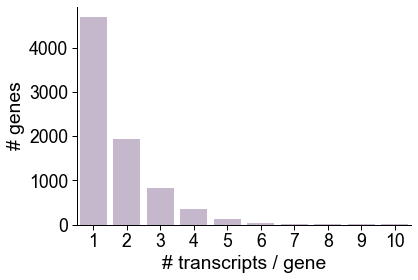

In [17]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

c_dict, order = get_biosample_colors(species='mouse')
c = c_dict[sample]
ax = sns.barplot(data=rep_df, x='n_iso', y='n_genes', color=c)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set(xlabel='# transcripts / gene', ylabel='# genes')

In [18]:
rep_df_2

,n_iso,4+,n_genes,total,perc,cumsum
0,1,False,4692,7998,58.664666,58.664666
1,2,False,1933,7998,24.168542,82.833208
2,3,False,822,7998,10.277569,93.110778
3,4+,True,551,7998,6.889222,100.000000


<Figure size 288x288 with 0 Axes>

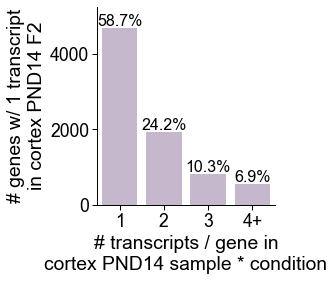

In [19]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

# and make a beautiful plot
figsize=(4,4)
plt.figure(figsize=figsize)
height = figsize[1]
width = figsize[0]
aspect = width/height

c_dict, order = get_biosample_colors(species='mouse')
c = c_dict[sample]
ax = sns.catplot(data=rep_df_2, x='n_iso', y='n_genes', color=c, kind='bar',
                 height=height, aspect=aspect)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set(xlabel='# transcripts / gene in\ncortex PND14 sample * condition', ylabel='# genes w/ 1 transcript\nin cortex PND14 F2', ylim=(0,5250))

def add_perc_2(ax, df):
    ylim = ax.get_ylim()[1]
    n_cats = len(ax.patches)
    for p in ax.patches:
        txt = '{:.1f}%'.format(df.loc[df.n_genes==p.get_height(), 'perc'].values[0])
        x = p.get_x() + p.get_width() / 2
        y = p.get_y() + p.get_height() + ylim*0.01
        ax.annotate(txt, (x, y), size=16, horizontalalignment='center')

add_perc_2(ax, rep_df_2)

fname = 'figures/cortex_14d_f_2_n_isos_per_gene_for_1_iso_library_genes.pdf'
plt.savefig(fname, dpi=500)

In [20]:
n_1 = rep_df.loc[rep_df.n_iso==1, 'n_genes'].values[0]
n_more = rep_df.loc[rep_df.n_iso!=1, 'n_genes'].sum(axis=0)
n_num = n_1
n = n_1+n_more
print('{:.2f}% ({}/{}) of genes w/ 1 isoform from {} still have 1 isoform in entire {} sample * condition'.format((n_num/n)*100, n_num, n, dataset, sample))

58.66% (4692/7998) of genes w/ 1 isoform from cortex_14d_f_2 still have 1 isoform in entire cortex_14d sample * condition


In [21]:
# how many more reads did we gain when we looked at entire sample versus just this one dataset?
meta = pd.read_csv(m_lib_meta, sep='\t')
n_reads = meta.loc[meta.dataset==dataset, 'reads_post_talon'].values[0]
n_reads_tot = meta.loc[meta['sample']==sample, 'reads_post_talon'].sum(axis=0)
print(n_reads)
print(n_reads_tot)
print(n_reads_tot-n_reads)

762376
7134458
6372082


## Now make the above plot but binned by TPM to see how highly expressed the newly added transcripts are by rank

In [22]:
ab_df = pd.read_csv(m_filt_ab, sep='\t')
ab_df, ic_ids = get_tpm_table(ab_df,
               how='iso',
               species='mouse',
               gene_subset=gene_subset,
               min_tpm=min_tpm,
               groupby='sample',
               sample=sample)

samp_df = ab_df[[sample]]
samp_df = samp_df[samp_df[sample]>=min_tpm]

Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 153398
# isos >= 1 tpm: 142504
Applying gene type and novelty subset
Averaging over biosample
Found 32 total samples
Number of isos reported: 139335


In [23]:
samp_df = samp_df.reset_index().rename({'index':'tid'}, axis=1)
samp_df['gid'] = samp_df.tid.str.split('[', expand=True)[0]
# samp_df.head()

In [24]:
# samp_df.loc[samp_df.gid.duplicated()]
# samp_df.loc[samp_df.gid=='ENSMUSG00000045216']

In [25]:
## samp_df = samp_df.loc[samp_df.gid.isin(gids)]
samp_df = samp_df.sort_values(by=sample, ascending=False)

samp_df['iso_rank'] = samp_df.groupby('gid').cumcount()+1
samp_df.loc[samp_df.gid=='ENSMUSG00000045216']

biosample,tid,cortex_14d,gid,iso_rank
235,"ENSMUSG00000045216[1,1,1]",33.787410,ENSMUSG00000045216,1
237,"ENSMUSG00000045216[3,2,1]",7.166481,ENSMUSG00000045216,2
236,"ENSMUSG00000045216[2,2,2]",4.479051,ENSMUSG00000045216,3
238,"ENSMUSG00000045216[4,2,1]",1.791620,ENSMUSG00000045216,4


In [26]:
samp_df.loc[samp_df.iso_rank>=max_n, 'iso_rank'] = col
samp_df.iso_rank.unique()

array([1, 2, 3, '4+'], dtype=object)

In [27]:
samp_df['log_tpm'] = np.log2(samp_df[sample])

In [29]:
dataset

'cortex_14d_f_2'

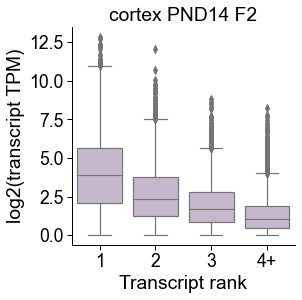

In [ ]:
# and make a beautiful plot
figsize=(4,4)
plt.figure(figsize=figsize)
height = figsize[1]
width = figsize[0]
aspect = width/height

ax = sns.boxplot(samp_df, y='log_tpm', x='iso_rank',
                 color=c_dict[sample])

ax.set(xlabel='Transcript rank',
       ylabel='log2(transcript TPM)',
       title='cortex PND14 F2')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fname = f'{dataset}_iso_tpm_by_rank.pdf'
plt.savefig(fname, dpi=500)

## How highly-expressed are the isoforms that we added by considering the entire sample vs just one library?

In [35]:
ab_df = pd.read_csv(m_filt_ab, sep='\t')
ab_df, ic_ids = get_tpm_table(ab_df,
               how='iso',
                species='mouse',
               gene_subset=gene_subset,
               min_tpm=min_tpm,
               groupby='library')

lib_df = ab_df[[dataset]]
lib_df = lib_df[lib_df[dataset]>=min_tpm]

meta = pd.read_csv(m_lib_meta, sep='\t')
sample = meta.loc[meta.dataset == dataset, 'sample'].values[0]

ab_df = pd.read_csv(m_filt_ab, sep='\t')
ab_df, ic_ids = get_tpm_table(ab_df,
               how='iso',
               species='mouse',
               gene_subset=gene_subset,
               min_tpm=min_tpm,
               groupby='sample',
               sample=sample)

samp_df = ab_df[[sample]]
samp_df = samp_df[samp_df[sample]>=min_tpm]

lib_df = lib_df.reset_index().rename({'annot_transcript_id':'tid',
                                       dataset: 'tpm'}, axis=1)
samp_df = samp_df.reset_index().rename({'index':'tid',
                                        sample: 'tpm'}, axis=1)

lib_df['source'] = dataset 
samp_df['source'] = sample

# which isoforms were added (ie weren't in the library-level quantification)
new_tids = list(set(samp_df.tid.tolist())-set(lib_df.tid.tolist()))
samp_df['t_in_lib'] = True
samp_df.loc[samp_df.tid.isin(new_tids), 't_in_lib'] = False

df = pd.concat([samp_df, lib_df], axis=0)
df['log_tpm'] = np.log2(df.tpm)

Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 153398
# isos >= 1 tpm: 142504
Applying gene type and novelty subset
Number of isos reported: 139335
Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 153398
# isos >= 1 tpm: 142504
Applying gene type and novelty subset
Averaging over biosample
Found 32 total samples
Number of isos reported: 139335


<AxesSubplot:xlabel='source', ylabel='log_tpm'>

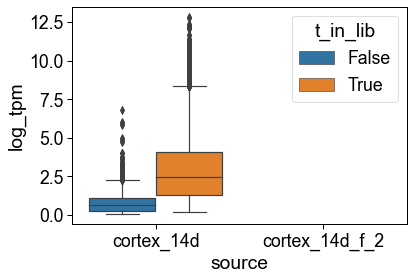

In [75]:

sns.boxplot(df, x='source', hue='t_in_lib', y='log_tpm')

In [83]:
dataset

'cortex_14d_f_2'

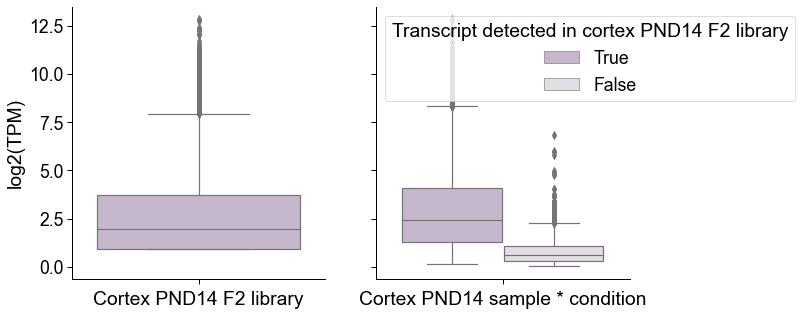

In [36]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5), sharey=True)

temp = df.loc[df.source == dataset].copy(deep=True)
sns.boxplot(temp, x='source', y='log_tpm', ax=axes[0], color=c_dict[sample])

temp = df.loc[df.source == sample].copy(deep=True)
temp.t_in_lib = temp.t_in_lib.astype('category').cat.reorder_categories([True, False], ordered=True)
c_dict_2, order_2 = get_shade_colors(c_dict[sample], [True, False])
sns.boxplot(temp, x='source', hue='t_in_lib', y='log_tpm',
            palette=c_dict_2, ax=axes[1])

axes[0].set(xlabel='Cortex PND14 F2 library')
axes[0].set(ylabel='log2(TPM)')

axes[1].set(ylabel='')
axes[1].set(xlabel='Cortex PND14 sample * condition')

plt.sca(axes[0])
plt.xticks(range(1), [''])

plt.sca(axes[1])
plt.xticks(range(1), [''])

plt.legend(title='Transcript detected in cortex PND14 F2 library', loc='upper left')

for ax in axes: 
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
fname = f'figures/{dataset}_expression_boxplot.pdf'
plt.savefig(fname, dpi=500)

In [81]:
x = temp.loc[(temp.source==sample)&(temp.t_in_lib==True)].log_tpm.tolist()
y = temp.loc[(temp.source==sample)&(temp.t_in_lib==False)].log_tpm.tolist()
st.mannwhitneyu(x,y)

MannwhitneyuResult(statistic=198340203.0, pvalue=0.0)

In [33]:
c_dict[sample]

'#c7b5cf'

In [34]:
# df['cat'] = np.nan
# df.loc[df.source==dataset, 'cat'] = 'Cortex PND14 F1 library'
# df.loc[df.new_t == False, 'cat'] = 'Cortex PND14 sample * condition transcripts'
# df.loc[df.new_t == False, 'cat'] = 'Cortex PND14 sample * condition added transcripts'

In [35]:
# df.source

In [36]:
# meta.loc[meta.dataset==dataset]

## How often are the new transcripts added part now predominant transcripts?

In [37]:
ab_df = pd.read_csv(m_filt_ab, sep='\t')
ab_df, ic_ids = get_tpm_table(ab_df,
               how='iso',
                species='mouse',
               gene_subset=gene_subset,
               min_tpm=min_tpm,
               groupby='library')

lib_df = ab_df[[dataset]]
lib_df = lib_df[lib_df[dataset]>=min_tpm]

meta = pd.read_csv(m_lib_meta, sep='\t')
sample = meta.loc[meta.dataset == dataset, 'sample'].values[0]

ab_df = pd.read_csv(m_filt_ab, sep='\t')
ab_df, ic_ids = get_tpm_table(ab_df,
               how='iso',
               species='mouse',
               gene_subset=gene_subset,
               min_tpm=min_tpm,
               groupby='sample',
               sample=sample)

samp_df = ab_df[[sample]]
samp_df = samp_df[samp_df[sample]>=min_tpm]

lib_df = lib_df.reset_index().rename({'annot_transcript_id':'tid',
                                       dataset: 'tpm'}, axis=1)
samp_df = samp_df.reset_index().rename({'index':'tid',
                                        sample: 'tpm'}, axis=1)

lib_df['source'] = dataset 
samp_df['source'] = sample

# which isoforms were added (ie weren't in the library-level quantification)
new_tids = list(set(samp_df.tid.tolist())-set(lib_df.tid.tolist()))
samp_df['t_in_lib'] = True
samp_df.loc[samp_df.tid.isin(new_tids), 't_in_lib'] = False

df = pd.concat([samp_df, lib_df], axis=0)
df['gid'] = df.tid.str.split('[', expand=True)[0]
df['log_tpm'] = np.log2(df.tpm)

df = df.sort_values(by='tpm', ascending=False)
df['iso_rank'] = df.groupby('gid').cumcount()+1

Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2087: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2086: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 153398
# isos >= 1 tpm: 142504
Applying gene type and novelty subset
Number of isos reported: 139335
Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 153398
# isos >= 1 tpm: 142504
Applying gene type and novelty subset
Averaging over biosample
Found 32 total samples
Number of isos reported: 139335


In [38]:
df = df.loc[df.source==sample]

In [39]:
df.head()

,tid,tpm,source,t_in_lib,gid,log_tpm,iso_rank
32846,"ENSMUSG00000072235[1,1,1]",7387.936886,cortex_14d,True,ENSMUSG00000072235,12.850956,1
28902,"ENSMUSG00000058672[1,1,1]",6877.168751,cortex_14d,True,ENSMUSG00000058672,12.747599,1
24988,"ENSMUSG00000019505[3,1,1]",5304.408077,cortex_14d,True,ENSMUSG00000019505,12.372976,1
18235,"ENSMUSG00000037852[1,1,1]",5058.501510,cortex_14d,True,ENSMUSG00000037852,12.304494,2
15070,"ENSMUSG00000002985[2,3,2]",4813.191979,cortex_14d,True,ENSMUSG00000002985,12.232778,2


In [40]:
n_num = len(df.loc[(df.t_in_lib==False)&\
                   (df.iso_rank==1)])
n = len(df.index)
print(f'{n_num}/{n} {perc(n_num,n):.2f}% of transcripts detected in {sample} that are are not in {dataset} are predominant transcripts')


836/40107 2.08% of transcripts detected in cortex_14d that are are not in cortex_14d_f_2 are predominant transcripts


## Are we usually adding new ICs, TSSs, or TESs?

In [41]:
ab_df = pd.read_csv(m_filt_ab, sep='\t')
ab_df, ic_ids = get_tpm_table(ab_df,
               how='iso',
                species='mouse',
               gene_subset=gene_subset,
               min_tpm=min_tpm,
               groupby='library')

lib_df = ab_df[[dataset]]
lib_df = lib_df[lib_df[dataset]>=min_tpm]

meta = pd.read_csv(m_lib_meta, sep='\t')
sample = meta.loc[meta.dataset == dataset, 'sample'].values[0]

ab_df = pd.read_csv(m_filt_ab, sep='\t')
ab_df, ic_ids = get_tpm_table(ab_df,
               how='iso',
               species='mouse',
               gene_subset=gene_subset,
               min_tpm=min_tpm,
               groupby='sample',
               sample=sample)

samp_df = ab_df[[sample]]
samp_df = samp_df[samp_df[sample]>=min_tpm]

lib_df = lib_df.reset_index().rename({'annot_transcript_id':'tid',
                                       dataset: 'tpm'}, axis=1)
samp_df = samp_df.reset_index().rename({'index':'tid',
                                        sample: 'tpm'}, axis=1)

lib_df['source'] = dataset 
samp_df['source'] = sample

# which isoforms were added (ie weren't in the library-level quantification)
new_tids = list(set(samp_df.tid.tolist())-set(lib_df.tid.tolist()))
samp_df['t_in_lib'] = True
samp_df.loc[samp_df.tid.isin(new_tids), 't_in_lib'] = False

df = pd.concat([samp_df, lib_df], axis=0)
df['gid'] = df.tid.str.split('[', expand=True)[0]
df['log_tpm'] = np.log2(df.tpm)

df = df.sort_values(by='tpm', ascending=False)
df['iso_rank'] = df.groupby('gid').cumcount()+1

Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2087: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2086: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 153398
# isos >= 1 tpm: 142504
Applying gene type and novelty subset
Number of isos reported: 139335
Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 153398
# isos >= 1 tpm: 142504
Applying gene type and novelty subset
Averaging over biosample
Found 32 total samples
Number of isos reported: 139335


In [42]:
df = df.loc[(df.source==sample)&\
            (df.t_in_lib==False)].copy(deep=True)
temp = pd.DataFrame()
for feat in ['tss', 'tes', 'ic']:
    df = add_feat(df, kind=feat, col='tid') 
    temp2 = df[[feat]].copy(deep=True)
    temp2['feat_type'] = feat
    temp2.rename({feat: 'feat'}, axis=1, inplace=True)
    temp = pd.concat([temp, temp2], axis=0)

In [43]:
temp

,feat,feat_type
8453,ENSMUSG00000095937_1,tss
39306,ENSMUSG00000082926_1,tss
24162,ENSMUSG00000078965_1,tss
20170,ENSMUSG00000079884_1,tss
25423,ENSMUSG00000081485_1,tss
...,...,...
9027,ENSMUSG00000028859_1,ic
286,ENSMUSG00000026112_4,ic
5283,ENSMUSG00000017667_2,ic
37824,ENSMUSG00000049562_2,ic


In [44]:
df = temp.groupby('feat_type').nunique().reset_index()

In [45]:
c_dict, order = get_feat_triplet_colors(cats=temp.feat_type.unique().tolist())

In [46]:
df

,feat_type,feat
0,ic,6598
1,tes,5773
2,tss,5586


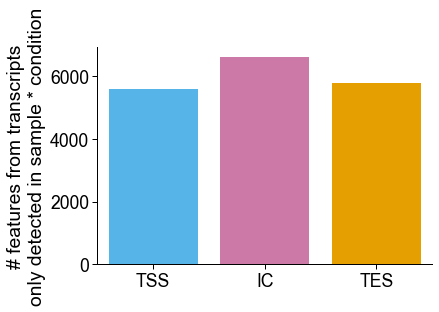

In [47]:
ax = sns.barplot(data=df, y='feat', x='feat_type', palette=c_dict,
                 saturation=1, order=order)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
_ = ax.set(xlabel='', ylabel='# features from transcripts\nonly detected in sample * condition',
       xticklabels=[t.upper() for t in order])

## What about individual features uniquely detected, rather than those from the transcirpts?

In [90]:
feats = ['tss', 'ic', 'tes']
n_novel = []

for feat in feats:
    ab_df = pd.read_csv(m_filt_ab, sep='\t')
    ab_df, ic_ids = get_tpm_table(ab_df,
                   how=feat,
                    species='mouse',
                   gene_subset=gene_subset,
                   min_tpm=min_tpm,
                   groupby='library')

    lib_df = ab_df[[dataset]]
    lib_df = lib_df[lib_df[dataset]>=min_tpm]

    meta = pd.read_csv(m_lib_meta, sep='\t')
    sample = meta.loc[meta.dataset == dataset, 'sample'].values[0]

    ab_df = pd.read_csv(m_filt_ab, sep='\t')
    ab_df, ic_ids = get_tpm_table(ab_df,
                   how=feat,
                   species='mouse',
                   gene_subset=gene_subset,
                   min_tpm=min_tpm,
                   groupby='sample',
                   sample=sample)

    samp_df = ab_df[[sample]]
    samp_df = samp_df[samp_df[sample]>=min_tpm]

    lib_df = lib_df.reset_index().rename({feat:'id',
                                           dataset: 'tpm'}, axis=1)
    samp_df = samp_df.reset_index().rename({'index':'id',
                                            sample: 'tpm'}, axis=1)

    lib_df['source'] = dataset 
    samp_df['source'] = sample

    # which isoforms were added (ie weren't in the library-level quantification)
    new_tids = list(set(samp_df['id'].tolist())-set(lib_df['id'].tolist()))
    samp_df['t_in_lib'] = True
    samp_df.loc[samp_df['id'].isin(new_tids), 't_in_lib'] = False

    df = pd.concat([samp_df, lib_df], axis=0)
    df['gid'] = df['id'].str.split('_', expand=True)[0]
    df['log_tpm'] = np.log2(df.tpm)

    df = df.sort_values(by='tpm', ascending=False)
    df['iso_rank'] = df.groupby('gid').cumcount()+1
    
    df = df.loc[(df.source==sample)&\
            (df.t_in_lib==False)].copy(deep=True)
    n = len(df.index)
    n_novel.append(n)
df = pd.DataFrame()
df['feat'] = feats
df['n_novel'] = n_novel

Calculating tss TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2087: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2086: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # tsss detected: 51152
# tsss >= 1 tpm: 46899
Applying gene type and novelty subset
Number of tsss reported: 44087
Calculating tss TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # tsss detected: 51152
# tsss >= 1 tpm: 46899
Applying gene type and novelty subset
Averaging over biosample
Found 32 total samples
Number of tsss reported: 44087
Calculating ic TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # ics detected: 93689
# ics >= 1 tpm: 87225
Applying gene type and novelty subset
Number of ics reported: 84485
Calculating ic TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # ics detected: 93689
# ics >= 1 tpm: 87225
Applying gene type and novelty subset
Averaging over biosample
Found 32 total samples
Number of ics reported: 84485
Calculating tes TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # tess detected: 64910
# tess >= 1 tpm: 58765
Applying gene type and novelty subset
Number of te

In [91]:
df

,feat,n_novel
0,tss,2042
1,ic,4838
2,tes,2386


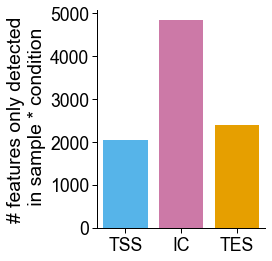

In [104]:
c_dict, order = get_feat_triplet_colors(cats=df.feat.unique().tolist())



ax = sns.barplot(data=df, y='n_novel', x='feat', palette=c_dict,
                 saturation=1, order=order)
ax.figure.set_size_inches(3,4)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
_ = ax.set(xlabel='', ylabel='# features only detected\n in sample * condition',
       xticklabels=[t.upper() for t in order])

fname = f'figures/{dataset}_n_feats_from_sample.pdf'
plt.savefig(fname, dpi=500)

In [107]:
df['total'] = df.n_novel.sum(axis=0)
df['perc'] = (df.n_novel/df.total)*100
n = df.total.values[0]
n_num = df.loc[df.feat=='ic'].n_novel.values[0]
print(f'{perc(n_num, n):.1f}% of features unique to sample * condition are ICs')

52.2% of features unique to sample * condition are ICs


## What about sector conservation?

In [19]:
dataset = 'cortex_14d_f_2'
df = pd.read_csv(f'{dataset}_triplets.tsv', sep='\t')
ca = cerberus.read(m_cerberus_h5)

In [20]:
ca.triplets = pd.concat([ca.triplets, df], axis=0)

In [21]:
ca.triplets.loc[(ca.triplets.source=='dataset_det')&\
                (ca.triplets.dataset==dataset), 'source'] = f'{dataset}_det'
ca.triplets.loc[(ca.triplets.source=='sample_det')&(ca.triplets['sample']=='cortex_14d'),
                'source'] = 'sample_cortex_14d'

ca.write(f'{dataset}_triplets_edited.h5')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:2718: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['Chromosome', 'Strand', 'source', 'Name'], dtype='object')]

  encoding=encoding,
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:2718: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['source', 'gid', 'sector', 'gname', 'sample', 'dataset'], dtype='object')]

  encoding=encoding,


In [22]:
df = compute_dists([ca, ca],
                   ['sample_cortex_14d', 
                   f'{dataset}_det'],
                   gene_subsets=[dist_gene_subset, dist_gene_subset],
                   ver=[m_ver,  m_ver],
                   gene_merge=['gid', 'gid'])

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


In [23]:
df['same_sect'] = df['sector_sample_cortex_14d'] == df[f'sector_{dataset}_det']

In [24]:
df[['gid', 'same_sect']].groupby('same_sect').nunique()

,gid
same_sect,
False,3860
True,7963


In [25]:
n = 3860+7963
n_num = 7963
print(f'{perc(n_num, n):.2f}% ({n_num}/{n}) of genes from {dataset} are in the same sector as the full sample * condition')

67.35% (7963/11823) of genes from cortex_14d_f_2 are in the same sector as the full sample * condition


## Sector bar plots and simplex plot

In [4]:
dataset = 'cortex_14d_f_2'
df = pd.read_csv(f'{dataset}_triplets.tsv', sep='\t')
ca = cerberus.read(m_cerberus_h5)
ca.triplets = pd.concat([ca.triplets, df], axis=0)

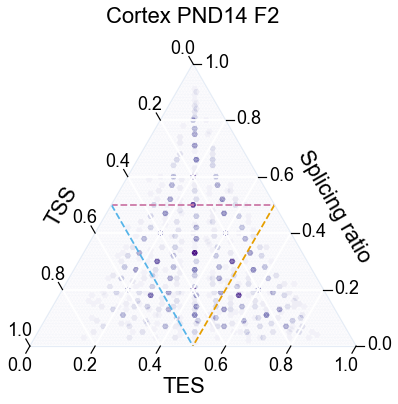

In [5]:
title = 'Cortex PND14 F2'
temp = ca.plot_simplex(top='splicing_ratio',
    density=True,
    density_scale=100,
    density_cmap='Purples',
    log_density=True,
    sectors=True,
    scatter=False,
    legend=False,
    title=title,
    size_scale=0.6,
    density_cbar=False,
    subset={'source': 'dataset_det', 'dataset': dataset},
    fname=f'figures/simplex_{dataset}.pdf')

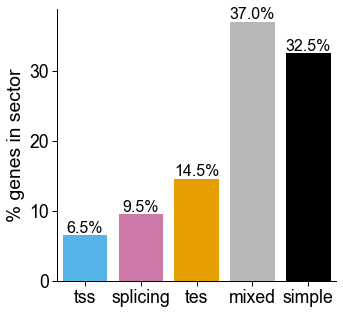

<Figure size 432x288 with 0 Axes>

In [6]:
temp = temp[['gid', 'sector']].groupby('sector').count().reset_index().rename({'gid': 'n_genes'}, axis=1)

temp['total'] = temp.n_genes.sum()
temp['perc'] = (temp['n_genes']/temp['total'])*100

sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(5,5))

c_dict, order = get_sector_colors()


ax = sns.barplot(data=temp, y='perc', x='sector',
                 palette=c_dict, order=order,
                 saturation=1)
                 # , height=3, aspect=1.2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('% genes in sector')
ax.set_xlabel('')

def add_perc_2(ax):
    ylim = ax.get_ylim()[1]
    n_cats = len(ax.patches)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        x = p.get_x() + p.get_width() / 2
        y = p.get_y() + p.get_height() + ylim*0.01
        ax.annotate(percentage, (x, y), size=16, horizontalalignment='center')

add_perc_2(ax)
fname = f'figures/{dataset}_genes_per_sector.pdf'
plt.savefig(fname, dpi=500)
plt.show()
plt.clf()